# **Загрузка модулей**



In [4]:
from keras.models import Model, load_model
from keras import backend as K
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adam
from keras.utils import to_categorical

from sklearn.metrics import confusion_matrix, classification_report 
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from skimage.io import imsave
import seaborn as sns
from tqdm import tqdm_notebook
from IPython.display import clear_output

import sys
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
sys.path.insert(1, 'drive/My Drive/Huawei')

from utils import mnist_reader, architecture, result
from utils.mnist_reader import load_mnist
from utils.architecture import FashionNet_conv1d
from utils.result import plot_confusion_matrix
from utils.preprocessing import shuffle_data, cut_data

Mounted at /content/drive


# **Задача**

Fashion-MNIST is a dataset of Zalando's article images—consisting of a training set of 60,000 examples and a test set of 10,000 examples. Each example is a 28x28 grayscale image, associated with a label from 10 classes. 

Each training and test example is assigned to one of the following labels:

    0: T-shirt/top
    1: Trouser
    2: Pullover
    3: Dress
    4: Coat
    5: Sandal
    6: Shirt
    7: Sneaker
    8: Bag
    9: Ankle boot 

# **Загрузка констант**


In [0]:
seed = 31
np.random.seed(seed)

data_path = 'drive/My Drive/Huawei/data'
#data_path = 'data'

file_name = 'model_conv1d'
#file_name = file_name+'_shuffle'
file_path = 'drive/My Drive/Huawei/weight/'+file_name+'.h5'
#file_path = 'weight/model_compress.h5'+file_name

K.set_image_data_format('channels_last')                
TRAIN = 60000
TEST = 10000
VALIDATION_SPLIT = 0.2
EPOCHS = 50
BATCH_SIZE = 256                                       
VERBOSE = 1                                            
OPTIMIZER = Adam(lr=0.001, beta_1=0.9, beta_2=0.999)                               
IMG_ROWS, IMG_COLS, IMG_CHANNELS = 28, 28, 1

CLASSES = ['T-Top','Trouser','Pullover','Dress','Coat',
           'Sandal','Shirt','Sneaker','Bag','Ankle Boot']

---
# **1 Классификация Fashion MNIST**
---


## **Загрузка тренировочных и тестовых данных**


### *Загрузка данных*

In [0]:
x_train, y_train = load_mnist(data_path, kind='train')
x_test, y_test = load_mnist(data_path, kind='t10k')

x_train_csv = pd.read_csv(data_path+'/fashion-mnist_train.csv')
x_test_csv = pd.read_csv(data_path+'/fashion-mnist_test.csv')

### *Визуализация данных*

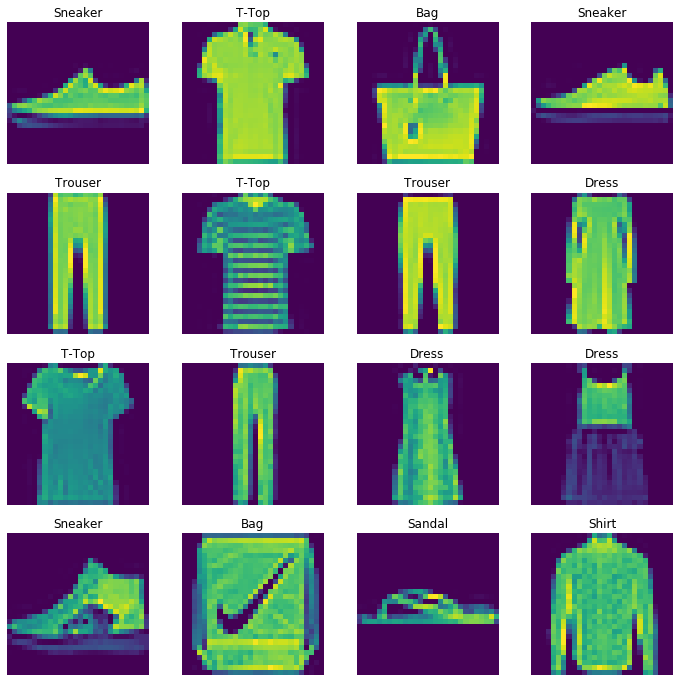

In [21]:
fig, axes = plt.subplots(4, 4, figsize = (12,12))
for row in axes:
    for axe in row:
        index = np.random.randint(60000)
        img = x_train_csv.drop('label', axis=1).values[index].reshape(28,28)
        cloths = x_train_csv['label'][index]
        axe.imshow(img)
        axe.set_title(CLASSES[cloths])
        axe.set_axis_off()

### *Проверяем количество объектов каждого класса*

Text(0.5, 0.98, 'TEST DATA')

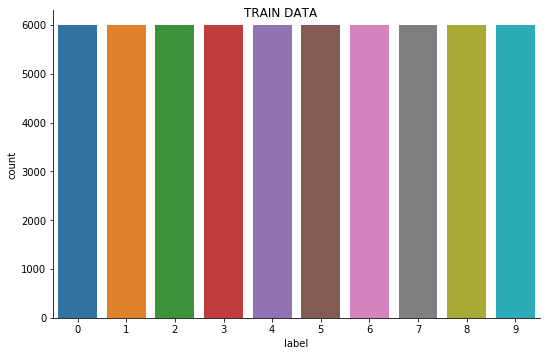

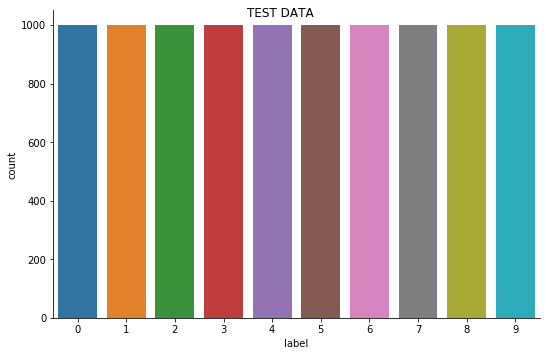

In [19]:
graph1 = sns.catplot(x='label', data=x_train_csv, kind='count', 
                     height=5, aspect= 1.5)
graph1.fig.suptitle('TRAIN DATA')

graph2 =sns.catplot(x='label', data=x_test_csv, kind='count', 
                    height=5, aspect= 1.5)
graph2.fig.suptitle('TEST DATA')

### *Сжатие данных до отрезка [0, 1]*

In [0]:
x_train = x_train.reshape((TRAIN, IMG_ROWS, IMG_COLS))
x_test = x_test.reshape((TEST, IMG_ROWS, IMG_COLS))

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

x_train = x_train[:, :, :, np.newaxis]
x_test = x_test[:, :, :, np.newaxis]

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

## **Обучение сети**

### *Компилируем модель и создаем чекпоинт файл*

In [0]:
model = FashionNet_conv1d(IMG_ROWS, IMG_COLS, IMG_CHANNELS, OPTIMIZER)
model_checkpoint = ModelCheckpoint(filepath=file_path, 
                                   monitor='val_loss', save_best_only=True)

### *Архитектура модели*



In [0]:
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 28, 28, 16)        32        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 26, 16)        784       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 26, 64)        1088      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 28, 13, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 28, 13, 64)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 28, 13, 32)        2080

### *Запуск обучения*

In [0]:
history = model.fit(x_train, y_train, 
                    batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    verbose=VERBOSE, shuffle=True, 
                    validation_split=VALIDATION_SPLIT, 
                    callbacks=[model_checkpoint])

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 7s 144us/step - loss: 0.8280 - acc: 0.7087 - val_loss: 0.4174 - val_acc: 0.8564
Epoch 2/50
48000/48000 [==============================] - 3s 69us/step - loss: 0.5025 - acc: 0.8245 - val_loss: 0.3510 - val_acc: 0.8734
Epoch 3/50
48000/48000 [==============================] - 3s 69us/step - loss: 0.4316 - acc: 0.8455 - val_loss: 0.3333 - val_acc: 0.8770
Epoch 4/50
48000/48000 [==============================] - 3s 69us/step - loss: 0.3992 - acc: 0.8569 - val_loss: 0.3065 - val_acc: 0.8876
Epoch 5/50
48000/48000 [==============================] - 3s 70us/step - loss: 0.3673 - acc: 0.8675 - val_loss: 0.2899 - val_acc: 0.8930
Epoch 6/50
48000/48000 [==============================] - 3s 69us/step - loss: 0.3504 - acc: 0.8760 - val_loss: 0.2760 - val_acc: 0.9005
Epoch 7/50
48000/48000 [==============================] - 3s 69us/step - loss: 0.3380 - acc: 0.8785 - val_loss: 0.2695 - val_ac

### *Строим графики обучения*

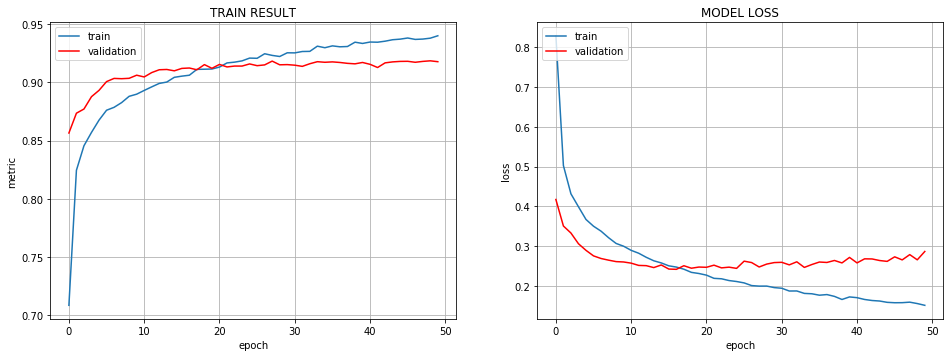

In [0]:
plt.figure(figsize=(16, 12))
plt.subplot(221)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'], 'r')
plt.title('TRAIN RESULT')
plt.ylabel('metric')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.grid()
plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], 'r')
plt.title('MODEL LOSS')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.grid()
plt.show()

## **Проверка результатов**

### *Загружаем модель*

In [0]:
model = load_model(file_path)

### *Делаем предсказания для тестовой выборки*

In [0]:
y_pred = model.predict(x_test)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 

### *Confusion Matrix*

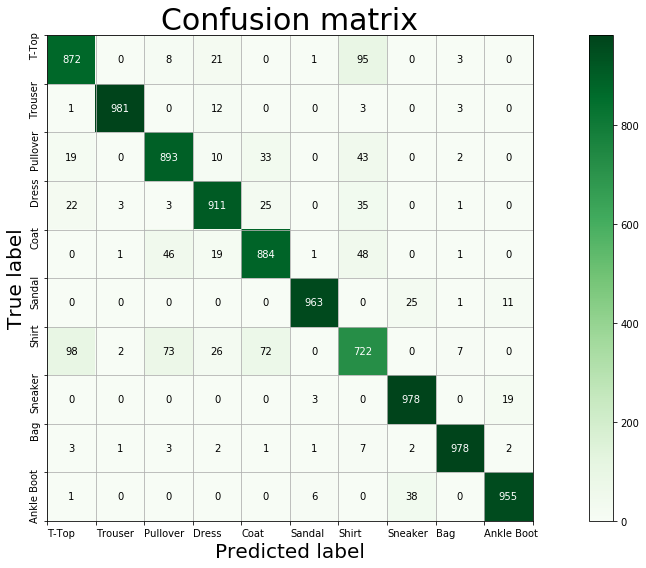

In [0]:
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
plot_confusion_matrix(16, 8, confusion_mtx, CLASSES)

### *Precision, Recall and F1-score*

In [0]:
print(classification_report(y_true, y_pred_classes, target_names = CLASSES))
micro_f1 = f1_score(y_true, y_pred_classes, average='micro')
micro_pre = precision_score(y_true, y_pred_classes, average='micro')
micro_rec = recall_score(y_true, y_pred_classes, average='micro')
formar_s = '   {}       {:.2}      {:.2}      {:.2}     {}'
print(formar_s.format('micro avg', micro_pre, micro_rec, micro_f1, y_true.shape[0]))


              precision    recall  f1-score   support

       T-Top       0.86      0.87      0.87      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.87      0.89      0.88      1000
       Dress       0.91      0.91      0.91      1000
        Coat       0.87      0.88      0.88      1000
      Sandal       0.99      0.96      0.98      1000
       Shirt       0.76      0.72      0.74      1000
     Sneaker       0.94      0.98      0.96      1000
         Bag       0.98      0.98      0.98      1000
  Ankle Boot       0.97      0.95      0.96      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000

   micro avg       0.91      0.91      0.91     10000


---
# **2 Случайный порядок строк**
---



## Загружаем тренировочные и тестовые данные 
Перемешиваем строчки каждого изображения

In [0]:
x_train, y_train = load_mnist(data_path, kind='train')
x_test, y_test = load_mnist(data_path, kind='t10k')

x_train = x_train.reshape((TRAIN, IMG_ROWS, IMG_COLS))
x_test = x_test.reshape((TEST, IMG_ROWS, IMG_COLS))

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

x_train_shuffle, x_test_shuffle = shuffle_data(x_train, x_test)

## *Random shuffle picture*

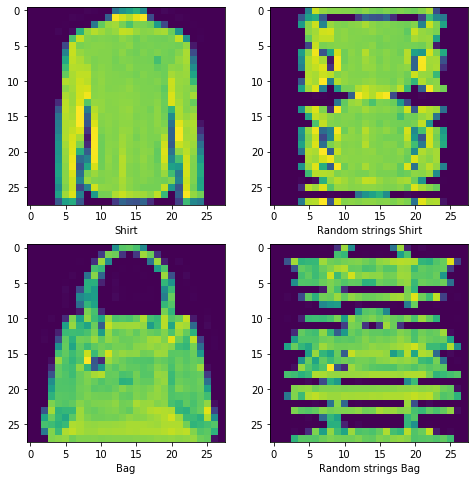

In [0]:
num1 = random.randint(0, 60000)
num2 = random.randint(0, 60000)

plt.figure(figsize=(8, 8))
plt.subplot(221)
plt.xlabel(CLASSES[y_train[num1]])
plt.imshow(x_train[num1])
plt.subplot(222)
plt.xlabel('Random strings '+CLASSES[y_train[num1]])
plt.imshow(x_train_shuffle[num1])
plt.subplot(223)
plt.xlabel(CLASSES[y_train[num2]])
plt.imshow(x_train[num2])
plt.subplot(224)
plt.xlabel('Random strings '+CLASSES[y_train[num2]])
plt.imshow(x_train_shuffle[num2])
plt.show()
plt.close()

Можно заметить, что некоторые картинки после перемешивания строк стали похожи друг на друга.

In [0]:
x_train_shuffle = x_train_shuffle[:, :, :, np.newaxis]
x_test_shuffle = x_test_shuffle[:, :, :, np.newaxis]

y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

## *Обучение новой сети*

In [0]:
model = FashionNet_conv1d(IMG_ROWS, IMG_COLS, IMG_CHANNELS, OPTIMIZER)
model_checkpoint = ModelCheckpoint(filepath=file_path, 
                                   monitor='val_loss', save_best_only=True)

In [0]:
history = model.fit(x_train_shuffle, y_train, 
                    batch_size=BATCH_SIZE, epochs=EPOCHS, 
                    verbose=VERBOSE, shuffle=True, 
                    validation_split=VALIDATION_SPLIT, 
                    callbacks=[model_checkpoint])

Train on 48000 samples, validate on 12000 samples
Epoch 1/50
48000/48000 [==============================] - 13s 281us/step - loss: 1.1804 - acc: 0.5674 - val_loss: 0.7007 - val_acc: 0.7388
Epoch 2/50
48000/48000 [==============================] - 9s 188us/step - loss: 0.7929 - acc: 0.7064 - val_loss: 0.5997 - val_acc: 0.7729
Epoch 3/50
48000/48000 [==============================] - 9s 189us/step - loss: 0.6998 - acc: 0.7400 - val_loss: 0.5633 - val_acc: 0.8011
Epoch 4/50
48000/48000 [==============================] - 9s 188us/step - loss: 0.6574 - acc: 0.7588 - val_loss: 0.5277 - val_acc: 0.8099
Epoch 5/50
48000/48000 [==============================] - 9s 189us/step - loss: 0.6155 - acc: 0.7759 - val_loss: 0.4981 - val_acc: 0.8222
Epoch 6/50
48000/48000 [==============================] - 9s 188us/step - loss: 0.5889 - acc: 0.7850 - val_loss: 0.4833 - val_acc: 0.8258
Epoch 7/50
48000/48000 [==============================] - 9s 190us/step - loss: 0.5636 - acc: 0.7945 - val_loss: 0.4697 -

## *Графики обучения*

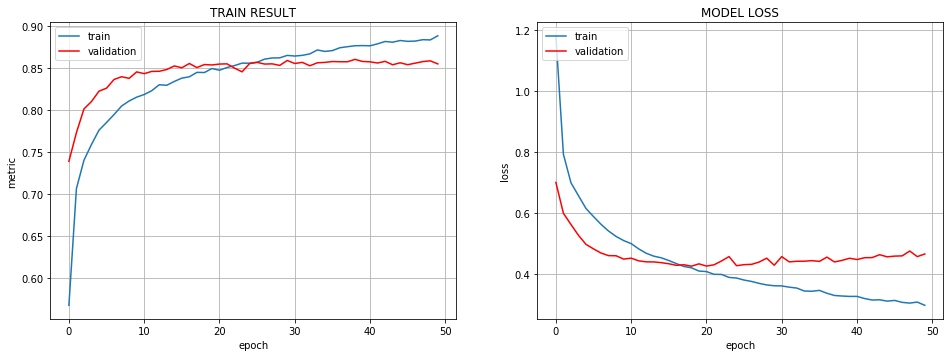

In [0]:
plt.figure(figsize=(16, 12))
plt.subplot(221)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'], 'r')
plt.title('TRAIN RESULT')
plt.ylabel('metric')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.grid()
plt.subplot(222)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], 'r')
plt.title('MODEL LOSS')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc = 'upper left')
plt.grid()
plt.show()

## *Предсказания на тестовой выборке*

In [0]:
y_pred = model.predict(x_test_shuffle)
y_pred_classes = np.argmax(y_pred, axis = 1) 
y_true = np.argmax(y_test, axis = 1) 

## *Confusion matrix*

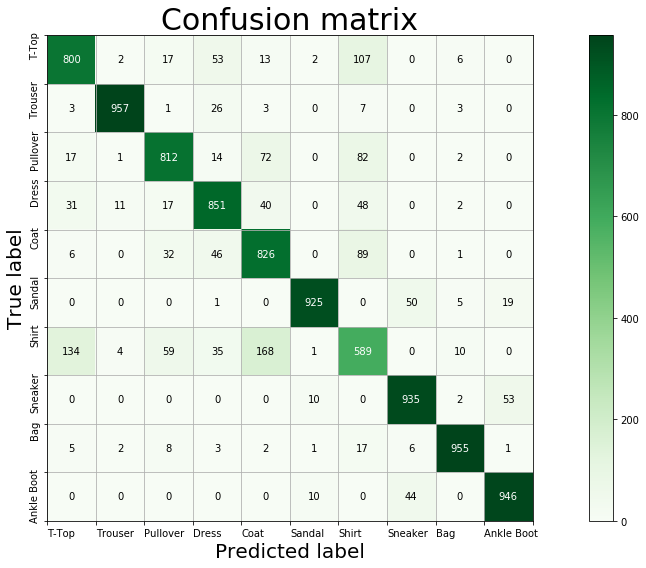

In [0]:
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
plot_confusion_matrix(16, 8, confusion_mtx, CLASSES)

## *Precision, Recall and F1-score*

In [0]:
print(classification_report(y_true, y_pred_classes, target_names = CLASSES))
micro_f1 = f1_score(y_true, y_pred_classes, average='micro')
micro_pre = precision_score(y_true, y_pred_classes, average='micro')
micro_rec = recall_score(y_true, y_pred_classes, average='micro')
formar_s = '   {}       {:.2}      {:.2}      {:.2}     {}'
print(formar_s.format('micro avg', micro_pre, micro_rec, micro_f1, y_true.shape[0]))

              precision    recall  f1-score   support

       T-Top       0.78      0.82      0.80      1000
     Trouser       0.97      0.96      0.96      1000
    Pullover       0.81      0.84      0.83      1000
       Dress       0.83      0.84      0.84      1000
        Coat       0.78      0.77      0.77      1000
      Sandal       0.96      0.92      0.94      1000
       Shirt       0.62      0.56      0.59      1000
     Sneaker       0.90      0.94      0.92      1000
         Bag       0.96      0.97      0.96      1000
  Ankle Boot       0.94      0.94      0.94      1000

    accuracy                           0.86     10000
   macro avg       0.86      0.86      0.86     10000
weighted avg       0.86      0.86      0.86     10000

   micro avg       0.86      0.86      0.86     10000


Видно, что кажество классификатора немного ухудшилось из-за того, что некоторые картинки разных классов стали похожи друг на друга.

---
# **3 Неравномерное количество объектов каждого класса**
---

## **Формулы**

$\quad Precision_i = \frac{TP_i}{TP_i + FP_i} $

$\quad Recall_i = \frac{TP_i}{TP_i + FN_i} $

$\quad Macro\;Average\;Precision= \frac{\sum\limits_{i=1}^{10}Precision_i}{10}$

$\quad Macro\;Average\;Recall= \frac{\sum\limits_{i=1}^{10}Recall_i}{10} $

$\quad Micro\;Average\;Precision= \frac{\sum\limits_{i=1}^{10} TP_i}
{\sum\limits_{i=1}^{10} TP_i + \sum\limits_{i=1}^{10} FP_i} $

$\quad Micro\;Average\;Precision= \frac{\sum\limits_{i=1}^{10} TP_i}
{\sum\limits_{i=1}^{10} TP_i + \sum\limits_{i=1}^{10} FN_i} $


## *Загрузка и обрезка тестовых данных*

In [23]:
model = load_model(file_path)

x_train, y_train = load_mnist(data_path, kind='train')
x_test, y_test = load_mnist(data_path, kind='t10k')

x_test = x_test.reshape((TEST, IMG_ROWS, IMG_COLS))
x_test = x_test.astype('float32')
x_test /= 255

x_test_cut, y_test_cut = cut_data(x_test, y_test)

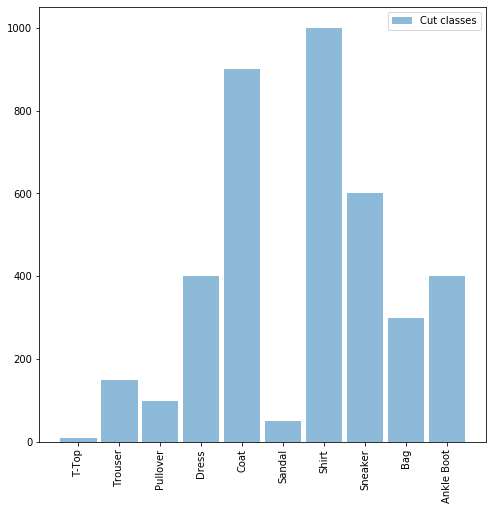

In [12]:
plt.figure(figsize=(8, 8))
plt.hist(y_test_cut, bins=np.arange(len(CLASSES) + 1), rwidth=0.9, 
         label="Cut classes", alpha=0.5)
plt.xticks(np.arange(len(CLASSES)) + 0.5, CLASSES, rotation = 90)
plt.legend(loc="best")
plt.show()

Видим, что тестовые классы получились несбалансированными.

In [0]:
x_test_cut = np.array(x_test_cut)
y_test_cut = np.array(y_test_cut)
y_true = y_test_cut
x_test_cut = x_test_cut[:, :, :, np.newaxis]
y_test_cut = to_categorical(y_test_cut, num_classes=10)
y_pred = model.predict(x_test_cut)
y_pred_classes = np.argmax(y_pred, axis = 1) 

## *Confusion Matrix*

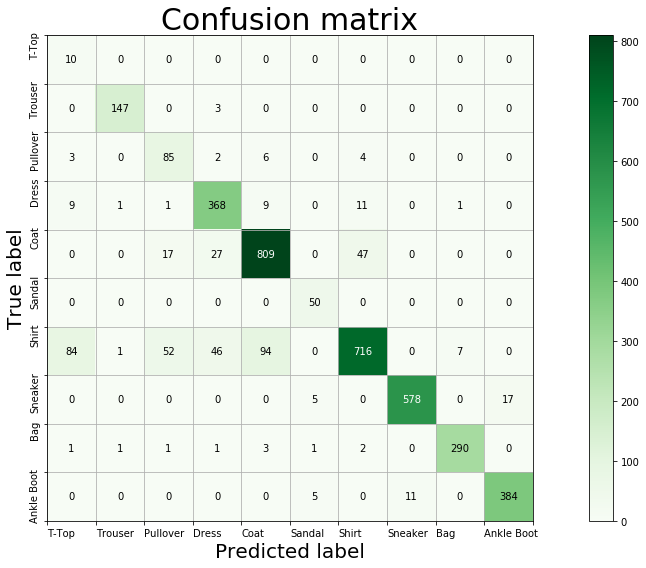

In [34]:
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
plot_confusion_matrix(16, 8, confusion_mtx, CLASSES)

## *Precision, Recall and F1-score*

In [35]:
print(classification_report(y_true, y_pred_classes, target_names = CLASSES))
micro_f1 = f1_score(y_true, y_pred_classes, average="micro")
micro_pre = precision_score(y_true, y_pred_classes, average="micro")
micro_rec = recall_score(y_true, y_pred_classes, average="micro")
formar_s = '   {}       {:.2}      {:.2}      {:.2}      {}'
print(formar_s.format('micro avg', micro_pre, micro_rec, micro_f1, y_true.shape[0]))

              precision    recall  f1-score   support

       T-Top       0.09      1.00      0.17        10
     Trouser       0.98      0.98      0.98       150
    Pullover       0.54      0.85      0.66       100
       Dress       0.82      0.92      0.87       400
        Coat       0.88      0.90      0.89       900
      Sandal       0.82      1.00      0.90        50
       Shirt       0.92      0.72      0.80      1000
     Sneaker       0.98      0.96      0.97       600
         Bag       0.97      0.97      0.97       300
  Ankle Boot       0.96      0.96      0.96       400

    accuracy                           0.88      3910
   macro avg       0.80      0.93      0.82      3910
weighted avg       0.91      0.88      0.89      3910

   micro avg       0.88      0.88      0.88      3910


## *Многократный самплинг обрезанной выборки*

In [42]:
inds = np.arange(x_test.shape[0])

micro_avgs = []
macro_precs = []
macro_recs = []

for _ in range(1000):
    np.random.shuffle(inds)
    x_test_cut, y_test_cut = cut_data(x_test[inds, :, :], y_test[inds])

    x_test_cut = np.array(x_test_cut)
    y_test_cut = np.array(y_test_cut)
    y_true = y_test_cut
    x_test_cut = x_test_cut[:, :, :, np.newaxis]
    y_test_cut = to_categorical(y_test_cut, num_classes=10)
    y_pred = model.predict(x_test_cut)
    y_pred_classes = np.argmax(y_pred, axis = 1)

    micro_avgs.append(precision_score(y_true, y_pred_classes, average="micro"))
    macro_precs.append(precision_score(y_true, y_pred_classes, average="macro"))
    macro_recs.append(recall_score(y_true, y_pred_classes, average="macro"))

    clear_output()
    print(_)

micro_avgs = np.array(micro_avgs)
macro_precs = np.array(macro_precs)
macro_recs = np.array(macro_recs)

999


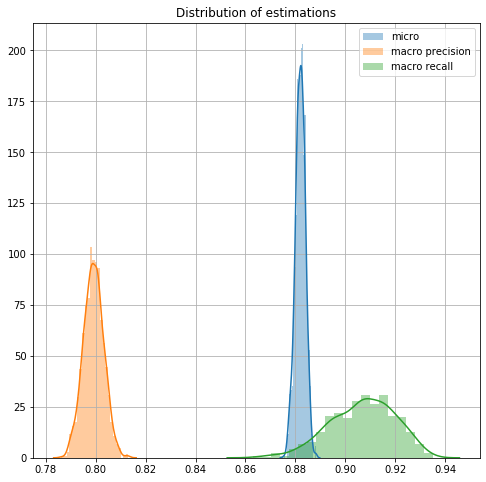

In [43]:
plt.figure(figsize=(8, 8))
sns.distplot(micro_avgs, label="micro")
sns.distplot(macro_precs, label="macro precision")
sns.distplot(macro_recs, label="macro recall")
plt.grid()
plt.legend(loc="best")
plt.title("Distribution of estimations")
plt.show()

## **Вывод**

$\quad$ 1) Согласно формулам выше, $Micro\;Average\;Precision/Recall$ есть отношение суммы диагональных элементов $Confusion\;matrix$ к сумме всех элементов, т.е. это по факту $Accuracy$.

$\quad$ 2) При вычислении $Accuracy$ используется больше элементов выборки, чем при вычислении $Precision/Recall$ для отдельных классов. Ввиду этого точность оценки $Accuracy$ оказывается выше, чем точность оценки $Macro\;Average\;Precision/Recall$, как мы видим на последнем рисунке.

$\quad$ * В рамках данной задачи, и в случае, если классы представлены неравномерно, лучше использовать $Micro\;Average\;Precision/Recall$ поскольку данная метрика точнее отражает качество работы классификатора. Однако, отмечу что использование данной метрики, равно как и $Macro\;Average\;Precision/Recall$ предполагает, что классы одинаково важны в контексте задачи.

$\quad$ * В том случае, если бы контекст задачи был бы другой, было бы лучше использовать не просто $Micro\;/Macro\;Average\;Precision/Recall$, а некую кастомную метрику. В качестве примера я хотел бы рассмотреть задачу классификации поломок на оборудовании. Допустим имеется три взаимоисключающих класса: поломка класса А, поломка класса Б, исправное оборудование. Допустим, поломку класса А дорого чинить если не обнаружить вовремя, а поломку класса Б относительно дёшево чинить даже если не обнаружить вовремя. В рамках такой задачи было бы лучше использовать взвешенный $Macro\;Average\;Recall$ с весами, соответствующими стоимости починки после соответствующей поломки, даже при неравномерном представлении классов.
